# Analyzing the Board Game _TEG_

Falta reemplazar las instancias de Risk por TEG

This notebook shows you how to use the probability tools from this site to analyze the odds in [_Risk_](https://en.wikipedia.org/wiki/Risk_(game%29), so you can make better decisions and hopefully improve your chances of winning.

If you're not familiar with _Risk_, you can [find an overview of how to play the game here](http://www.ultraboardgames.com/risk/game-rules.php).

In [2]:
from collections import deque, defaultdict
import itertools as it

In [3]:
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.3f}'.format

In [4]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set_context('notebook')
plt.style.use('ggplot')

This notebook uses the probability modules from the `pracpred` package developed on this site. You can [find more information about the package here](https://github.com/practicallypredictable/pracpred) and [here](https://pypi.python.org/pypi/pracpred/0.1.2).

In [5]:
from pracpred.prob import Prob, ProbDist

_Risk_ uses up to 5 six-sided dice to determine the outcome of attacks.

In [275]:
d6 = ProbDist(range(1,7))

In [276]:
d6

ProbDist({1: Prob(1, 6), 2: Prob(1, 6), 3: Prob(1, 6), 4: Prob(1, 6), 5: Prob(1, 6), 6: Prob(1, 6)})

### Attacks in _Risk_

We are going to use the term _attack_ to mean a clash between armies settled by a dice roll. In _Risk_, any particular attack can have up to 3 attacking armies and up to 2 defending armies. There are only 6 valid attacks.

In [277]:
# Attacks are represented as a tuple of (attacker armies, defender armies)
# Attacks do not include the attacker army required to remain in the territory from which the attack is launched
VALID_ATTACKS = [
    (1, 1),
    (1, 2),
    (1, 3),
    (2, 1),
    (2, 2),
    (2, 3),
    (3, 1),
    (3, 2),
    (3, 3),
]

We are going to use the term _battle_ to mean the larger conflict between two players over a particular territory. For example, if the attacker has 20 armies in China and wishes to attack the defender's 15 armies in Siberia, we call that a 19-on-15 battle. (In _Risk_, the attacker is required to keep one army in the territory from which he or she is attacking.)

Within this larger battle, each roll of the dice is an attack, which is at most 3-on-2. It's important to be clear about the difference between battles and attacks, since the attacker can halt the battle at any point, and potentially do something completely different.

We will begin defining some Python functions to help us represent the board game.

In [278]:
def attackers(attack):
    """Number of attackers in an attack."""
    return attack[0]

def defenders(attack):
    """Number of defenders in an attack."""
    return attack[1]

def total_armies(attack):
    """Total number of armies on both sides involved in an attck."""
    return attackers(attack)+defenders(attack)

### Dice Probabilities

We can compute all the possible dice rolls in advance, since there are only at most 5 dice rolled.

In [279]:
def get_roll_probs(attacks):
    """Probability distribution of rolls in attacks, by total number of dice rolled."""
    return {total_armies(attack): d6.repeated(total_armies(attack), product=True) for attack in attacks}

In [280]:
roll_probs = get_roll_probs(VALID_ATTACKS)
len(roll_probs)

5

In [281]:
roll_probs.keys()

dict_keys([2, 3, 4, 5, 6])

Every attack has at least 2 dice (one for the attacker and one for the defender). Notice also that we are not distinguishing between attacker and defender dice yet. This means that the 2-on-2 attack and the 3-on-1 attack will both use the roll probabilities for 4 dice, for example.

Let's look at the number of outcomes in the distribution for each set of dice.

In [282]:
for armies in roll_probs:
    print(armies, len(roll_probs[armies]))

2 36
3 216
4 1296
5 7776
6 46656


In our [previous post on dice rolls](http://practicallypredictable.com/2017/12/04/probability-distributions-dice-rolls/), we looked at the distribution of the sum of six-sided dice. For _Risk_, we need to generate the full [Cartesian product](https://en.wikipedia.org/wiki/Cartesian_product) of possible dice outcomes, because we are comparing the attacker and defender dice individually. That's why the number of outcomes for each set of dice is $6^n$, where $n$ is the number of dice rolled.

### Attacker versus Defender Rolls

Now we need to separately keep track of the attacker dice and the defender dice. We also need to sort each set of dice so we can determine the outcome of an attack.

In [283]:
def attacker_roll(attack, roll):
    """Dice rolled by attacker, sorted highest to lowest."""
    return sorted(roll[:attackers(attack)], reverse=True)

def defender_roll(attack, roll):
    """Dice rolled by defender, sorted highest to lowest."""
    return sorted(roll[-defenders(attack):], reverse=True)

We'll discuss in a little bit how to figure out how many dice to roll for a given attack.

Let's simulate a 3-on-2 attack to see how these functions work.

In [284]:
# Example 3-on-2 attack
attack = (3, 3)

In [285]:
roll = roll_probs[total_armies(attack)].choice()
roll

(4, 3, 5, 4, 3, 6)

In [286]:
attacker_roll(attack, roll)

[5, 4, 3]

In [287]:
defender_roll(attack, roll)

[6, 4, 3]

### Armies Lost

Now we can figure out how many armies each side loses in the attack. We compare the highest die roll by the attacker to the highest die roll by the defender. The attacker loses an army if his or her roll is less than or equal to the defender's roll. Otherwise, the defender loses an army.

If the attacker is rolling more than one die, and the defender is rolling two dice, we compare the attacker's second-highest die roll with the defender's lower die roll. The attacker loses an army if his or her second die roll is less than or equal to the defender's lower die roll. Otherwise, the defender loses an army.

In one attack, the most armies either side can lose is equal to the number of dice the defender rolls.

This function will determine how many armies each side loses in a particular attack given the dice rolls.

In [288]:
# EDITAR PARA CONSIDERAR TERCER DADO!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
def losses_from_roll(att_roll, def_roll):
    """Armies lost by (attacker, defender) based on dice roll."""
    if att_roll[0] > def_roll[0]:
        att_loses = 0
        def_loses = 1
    else:
        att_loses = 1
        def_loses = 0
    if len(def_roll) > 1 and len(att_roll) > 1:
        if att_roll[1] > def_roll[1]:
            def_loses += 1
        else:
            att_loses += 1
    if len(def_roll) > 2 and len(att_roll) > 2:
        if att_roll[2] > def_roll[2]:
            def_loses += 1
        else:
            att_loses += 1
    return (att_loses, def_loses)

In [289]:
losses_from_roll(attacker_roll(attack, roll), defender_roll(attack, roll))

(3, 0)

The above function can tell us how many armies each side loses for a given attacker roll and defender roll. To use the function, though, we first need to separate out the attacker dice from the defender dice.

### Armies Lost for Every Possible Attack

What we really want is for each possible type of attack to have it's own function, which will compute the armies lost for any particular dice roll. Here's a neat trick using [nested functions in Python](https://realpython.com/blog/python/inner-functions-what-are-they-good-for/) to do that.

In [290]:
def armies_lost(attack):
    """Create a function to calculate armies lost by (attacker, defender) for a given attack."""
    def inner_func(roll):
        att_roll = attacker_roll(attack, roll)
        def_roll = defender_roll(attack, roll)
        return losses_from_roll(att_roll, def_roll)
    return inner_func

In [291]:
type(armies_lost(attack))

function

So this function returned a function? Yes, in Python you can do that. The expression `armies_lost(attack)` looks like it should return a value of some sort, but in this case it returns a function.

Remember that the example attack we were playing with above is 3-on-2. The point of the nested function is that the `attack` parameter is known to the `inner_func` function, and gets hidden inside it. The inner function will always "remember" that it was initially called with the 3-on-2 attack parameter. We can call the returned function now with a particular dice roll, and the function will assume a 3-on-2 attack.

In [292]:
armies_lost(attack)(roll)

(3, 0)

Now we can build a function like this for every possible attack. Think of the `armies_lost()` function as a "factory" that builds and returns other functions, based on what type of attack we tell it to build.

In [293]:
def get_attack_losses(attacks):
    """Functions to calculate armies lost by attacker and defender for each type of attack."""
    return {attack: armies_lost(attack) for attack in attacks}

In [294]:
attack_losses = get_attack_losses(VALID_ATTACKS)
attack_losses

{(1, 1): <function __main__.armies_lost.<locals>.inner_func(roll)>,
 (1, 2): <function __main__.armies_lost.<locals>.inner_func(roll)>,
 (1, 3): <function __main__.armies_lost.<locals>.inner_func(roll)>,
 (2, 1): <function __main__.armies_lost.<locals>.inner_func(roll)>,
 (2, 2): <function __main__.armies_lost.<locals>.inner_func(roll)>,
 (2, 3): <function __main__.armies_lost.<locals>.inner_func(roll)>,
 (3, 1): <function __main__.armies_lost.<locals>.inner_func(roll)>,
 (3, 2): <function __main__.armies_lost.<locals>.inner_func(roll)>,
 (3, 3): <function __main__.armies_lost.<locals>.inner_func(roll)>}

Let's take a moment to review what's going on here. We now have 6 functions, one for each possible attack type. Given the type of attack, we can look up the right function to use and call it on a particular dice roll.

In [295]:
attack_losses[attack](roll)

(3, 0)

Let's test our function on 10 random 3-on-2 attacks to get a feel for how it works.

In [296]:
for roll in roll_probs[total_armies(attack)].sample(10):
    print('Att = {att_roll}, Def = {def_roll}, losses = {losses}'.format(
        att_roll=attacker_roll(attack, roll),
        def_roll=defender_roll(attack, roll),
        losses=attack_losses[attack](roll))
    )

Att = [6, 6, 2], Def = [5, 4, 1], losses = (0, 3)
Att = [5, 5, 5], Def = [1, 1, 1], losses = (0, 3)
Att = [6, 5, 4], Def = [4, 3, 2], losses = (0, 3)
Att = [6, 2, 2], Def = [4, 3, 1], losses = (1, 2)
Att = [6, 6, 1], Def = [3, 2, 2], losses = (1, 2)
Att = [6, 4, 3], Def = [6, 2, 1], losses = (1, 2)
Att = [6, 6, 2], Def = [4, 4, 2], losses = (1, 2)
Att = [6, 6, 2], Def = [6, 3, 1], losses = (1, 2)
Att = [6, 2, 1], Def = [4, 4, 2], losses = (2, 1)
Att = [5, 4, 2], Def = [1, 1, 1], losses = (0, 3)


### Probability of Attack Outcomes

Now we can start analyzing probabilities of attack outcomes. For each type of possible attack, we need to get all the possible dice rolls for that type, and then group the outcomes by how many armies are lost by each side.

This is reason I created a different army loss function for each type of attack. It makes it easy to do all the grouping in our probability framework.

In [297]:
roll_probs[total_armies(attack)].groupby(attack_losses[attack])

ProbDist({(0, 3): Prob(535, 3888), (1, 2): Prob(371, 1728), (2, 1): Prob(343, 1296), (3, 0): Prob(5957, 15552)})

Take a moment to unpack the above line. For the given attack type (in this example, 3-on-2), get the number of dice to roll (in this case, 5), and get all of the 7776 possible rolls for 5 dice. Then group those rolls by how many armies are lost in each roll outcome.

That's a lot going on in one line of Python. But it shows the power and generality of the probabilty modeling framework.

Now we can generate the distribution of armies lost for every possible attack, not just 3-on-2.

In [298]:
def get_loss_probs(attacks, roll_probs=None, attack_losses=None):
    """Distribution of armies lost by (attacker, defender) in an attack, by attack."""
    if not roll_probs:
        roll_probs = get_roll_probs(attacks)
    if not attack_losses:
        attack_losses = get_attack_losses(attacks)
    return {attack: roll_probs[total_armies(attack)].groupby(attack_losses[attack]) for attack in attacks}

In [299]:
# TIENE QUE DAR 9 ?!!!!!!
loss_probs = get_loss_probs(VALID_ATTACKS, roll_probs, attack_losses)
len(loss_probs)

9

In [300]:
for attack in loss_probs:
    print(attack, loss_probs[attack])

(1, 1) {(0, 1): 5/12, (1, 0): 7/12}
(1, 2) {(0, 1): 55/216, (1, 0): 161/216}
(1, 3) {(0, 1): 25/144, (1, 0): 119/144}
(2, 1) {(0, 1): 125/216, (1, 0): 91/216}
(2, 2) {(0, 2): 295/1296, (1, 1): 35/108, (2, 0): 581/1296}
(2, 3) {(0, 2): 979/7776, (1, 1): 1981/7776, (2, 0): 301/486}
(3, 1) {(0, 1): 95/144, (1, 0): 49/144}
(3, 2) {(0, 2): 1445/3888, (1, 1): 2611/7776, (2, 0): 2275/7776}
(3, 3) {(0, 3): 535/3888, (1, 2): 371/1728, (2, 1): 343/1296, (3, 0): 5957/15552}


That's it. Those are the possible outcomes in terms of armies lost in any given _Risk_ attack, along with the probability of that outcome happening.

### Battle Outcomes

It's great to analyze the armies lost in a given attack. But, what we ultimately are about is probability of winning a battle. Let's look at how to do that now.

For the attacker to win a battle, the defender's armies must be reduced to zero in the attacked territory. For the defender to win the battle, either the attacker's armies are reduced to zero (not including the one army that's required to remain behind), or the attacker calls of the attack.

#### A Simplified Example

Let's compute "by hand" the probability that the attacker wins a 2-on-1 battle. Later we'll figure out how to automate this for any possible battle.

In a 2-on-1 battle, the first attack is also 2-on-1. The possible outcomes are: the attacker loses an army, or the defender loses an army. If the defender loses an army, the battle is over.

The probability this happens is:

In [301]:
pA_W1 = loss_probs[(2, 1)][(0, 1)]
pA_W1

Prob(125, 216)

On the other hand, the attacker loses an army with probability:

In [302]:
pA_L1 = 1-pA_W1
pA_L1

Prob(91, 216)

Let's suppose the attacker is really aggressive and decides to continue the battle. This next attack would then be 1-on-1. The attacker wins this round with probability:

In [303]:
pA_W2 = loss_probs[(1, 1)][(0, 1)]
pA_W2

Prob(5, 12)

On the other hand, the defender prevails with probability:

In [304]:
pA_L2 = 1-pA_W2
pA_L2

Prob(7, 12)

The defender has the advantage in the 1-on-1 attack because the defender wins ties.

We assume that each dice roll is independent as usual. That means that we can use the [>>>multiplication rule for probabilities]() to combine events. In this case, the combined event we care about is that the attacker loses the first attack but wins the second attack. This probability is:

In [305]:
pA_L1W2 = pA_L1*pA_W2
pA_L1W2

Prob(455, 2592)

The overall probability the attacker wins the battle is the probability of winning in the first round, plus the probability of winning in the second round. The overall probability the attacker wins the 2-on-1 battle is:

In [306]:
pA_W = pA_W1 + pA_L1W2
pA_W

Prob(1955, 2592)

Similarly, the probability the attacker loses is the probability of losing in the first round times the probability of losing in the second round. This probability is:

In [307]:
pA_L = pA_L1*pA_L2
pA_L

Prob(637, 2592)

You may wonder, why do we **add** the probabilities for winning, but **multiply** the probabilities for losing?

Great question. It's because the attacker **either** wins in the first round, **or** she wins in the second round. They both cannot be true. In probability theory, these are called [mutually exclusive events](https://en.wikipedia.org/wiki/Mutual_exclusivity). You can add probabilities for mutually exclusive events because they don't overlap, if you want to know the probability that either one or the other event happens.

On the other hand, for the attacker to lose under our assumptions, she must lose the first round **and** the second round. Since these are independent events, we multiply probabilities to determine the probability that they both happen.

Of course, the probability that the attacker either wins or loses is one:

In [308]:
pA_W + pA_L

Prob(1, 1)

#### Some Assumptions

We made a few assumptions in the 2-on-1 battle example. First, we assumed that the first attack was 2-on-1. It might seem obvious that the attacker should use all her armies, but _Risk_ gives the players some choices on how many dice to roll in each attack.

It's an interesting question whether the attacker and defender should always roll the maximum number of dice allowed. We will look at that question in a future post. For now, let's make the common choice of always rolling the maximum number of dice.

We also assumed that the attacker continues to attack until losing the last possible army. We'll examine in a future post whether this is the best choice to make.

### Modeling Battles in Python

Let's define some more Python functions to help us represent any possible _Risk_ battle.

In [309]:
def attack_with(armies):
    """Attack with maximum number of armies allowed."""
    return min(3, attackers(armies))

def defend_with(armies):
    """Defend with maximum number of armies allowed."""
    return min(3, defenders(armies))

In [310]:
# Example battle starting armies
start = (3, 3)

In [311]:
attack_with(start)

3

In [312]:
defend_with(start)

3

In [313]:
def armies_left(armies, losses):
    """Armies remaining after losses."""
    return (attackers(armies)-attackers(losses), defenders(armies)-defenders(losses))

In [314]:
armies_left(start, (1, 0))

(2, 3)

#### More on Attack Outcomes

Now we want to focus on generating all the attack outcomes and their probabilities. We will also put each attack together into the larger context of the battle.

Recall that we already have all the probabilities for how many armies each side can lose for a given attack.

In [315]:
# ERROR!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
loss_probs[start]

ProbDist({(0, 3): Prob(535, 3888), (1, 2): Prob(371, 1728), (2, 1): Prob(343, 1296), (3, 0): Prob(5957, 15552)})

Now, we want to compute the probabilities for how many armies each side has left after a given attack.

In [316]:
def attack_outcomes(armies):
    """Distribution of remaining (attacker, defender) armies after an attack."""
    attack = (attack_with(armies), defend_with(armies))
    return {armies_left(armies, losses): loss_probs[attack][losses] for losses in loss_probs[attack]}

In [317]:
attack_outcomes(start)

{(0, 3): Prob(5957, 15552),
 (1, 2): Prob(343, 1296),
 (2, 1): Prob(371, 1728),
 (3, 0): Prob(535, 3888)}

#### Deciding When a Battle is Finished

Under our assumptions, a battle is over when either the attacker or defender has zero armies left.

In [318]:
def finished(attack):
    """True if either attacker or defender has lost battle."""
    return attackers(attack) == 0 or defenders(attack) == 0

In [319]:
def attacker_wins(outcome):
    """True if attacker won battle."""
    return attackers(outcome) > 0 and defenders(outcome) == 0

def defender_wins(outcome):
    """True if defender won battle."""
    return attackers(outcome) == 0 and defenders(outcome) > 0

#### Markov Chains

The hard part about modeling battles in _Risk_ is keeping track of all the possible ways a battle could go. Things were relatively simple for the 2-on-1 example, but for a 10-on-6 attack there are many more possibilities. We will look at exactly how many possibilities there are for various _Risk_ battles in a future post.

For now, I want to show you one way to solve this counting problem in Python, so you can see some useful results. This code may be a little hard to understand, but it's not that  different from how you would solve this  problem by hand if you had to. The framework used to model a general battle is called a [_Markov chain_](https://en.wikipedia.org/wiki/Markov_chain). Markov chains are named after the important Russian mathematician [Andrey Markov](https://en.wikipedia.org/wiki/Andrey_Markov). We will use Markov chains a lot on this site to analyze sports. This example using _Risk_ is meant as a simple introduction.

The basic idea is to start at the beginning of the battle. Since we know how many armies each side has, we know how many dice will be rolled in the first attack. We also can figure out the possible outcomes of that attack, and the distribution of possible armies each side will have left after the first attack.

#### State Space

Consider the _Risk_ battle as a random process. We can think of the number of armies each side has as the _state_ of the battle at any point in time. A [_state space_](https://en.wikipedia.org/wiki/State_space) is a set of values which a process can be in at any particular time. The state space has to tell us everything we would need to compute the probabilities for the next possible value of the process. The number of armies satisfies this requirement in _Risk_. If we know the number of armies, we know the number of dice to roll at each step, so we can figure out all the probabilities at each step.

#### Markov Property

Here's the important insight about _Risk_. The only thing that matters is the current state (i.e., how many armies each side has for the next attack). If the next attack is 3-on-2, it doesn't matter if the battle started 10-on-6 or 50-on-39. We may feel worse as the attacker if we started 50-on-39, but the probabilities of the 3-on-2 attack outcomes are the same either way.

This means that a _Risk_ battle satisfies the [_Markov property_](https://en.wikipedia.org/wiki/Markov_property). A random process has the Markov property if the future outcomes of the process only depend on the _current state_ of the process. Another way of saying this is that a process has the Markov property if it doesn't remember how it got to the current state. This is true of _Risk_.

#### Counting Battle States

You may wonder why this matters. It matters because we don't need to keep track of all the possible paths in a battle if the battle is a Markov process. We only need to keep track of the probability of being in each state. We can essentially forget all the prior information about how we got into a particular state.

This significantly lowers the difficulty in counting, as you'll see. There are much fewer states than the number of possible paths through a battle.

The initial state of the battle is just the number of armies each side has to start. Since the number of armies can never go up, we only have to represent the states that have armies less than or equal to the initial number, down to at worst zero armies for one side or the other. There are a finite number of possible states for any _Risk_ battle.

If we ever get to a state where one side has zero armies, the battle is over and the side with some armies remaining is the winner.

#### Accumulating the Attack Probabilities

In _Risk_, each attack is independent of the prior attacks in a battle. This is true because the dice rolls are independent.

As we saw in the [prior notebook on joint probabilities of independent events](https://github.com/practicallypredictable/posts/blob/master/notebooks/probability-part3-coin_flips-mult_probabilities.ipynb), you multiply the probabilities of two independent events to get the probability of the joint event that both occur.

In general, let's define the probability $P(S_{a,d})$ that the battle is ever in state $S_{a,d}$, where _a_ is the number of attacker armies and _d_ is the number of defender armies. Suppose we start the battle with 10 attacker and 6 defender armies. This state is $S_{10,6}$. We know there are three possible attack outcomes: the attacker loses 2 armies, the defender loses 2 armies, and each loses an army. Therefore, from the state $S_{10,6}$, the next possible states are $S_{8,6}$, $S_{9,5}$ and $S_{10,4}$. 

How does $P(S_{8,6})$ depend on $P(S_{10,6})$?

Think of $S_{8,6}$ being a joint probability based on two outcomes. The first outcome is that we were in $S_{10,6}$ on the prior step. The second outcome is that the attacker lost 2 armies in the 3-on-2 dice roll. Let's call this probability $P(A_{-2,3v2})$. These outcomes are independent, so we multiply the probabilities.

So is the following equation true?
$$P(S_{8,6}) = P(S_{10,6}) \times P(A_{-2,3v2})$$

In this case, yes, because there is only way one for the battle to get into the state $S_{8,6}$. If we were looking at the state $S_{7,5}$, we would have to be more careful. There are two ways we could get to $S_{7,5}$. The first is from $S_{8,6}$, after which the attacker and defender each lose an army. The other is from $S_{9,5}$, after which the attacker loses 2 armies.

Remember earlier in this post, we talked about mutually exclusive events. You can add probabilities of mutually exclusive events because the events don't overlap. In this example _Risk_ battle, $S_{8,6}$ and $S_{9,5}$ are mutually exclusive events. There is no way the battle can ever have been in one state if it was ever in the other state. Once you know the outcome of the first attack, you must be in one, and only one, of $S_{8,6}$, $S_{9,5}$ or $S_{10,4}$.

Now we have enough information to calculate $P(S_{7,5})$.
$$P(S_{7,5}) = P(S_{8,6}) \times P(A_{-1,3v2}) + P(S_{9,5}) \times P(A_{-2,3v2})$$

All this equation is saying is that the probability of being in any state equals the probability of being in a possible prior state, times the probability of going from that prior state to the current state, summed over all possible prior states.

This is true for any state. The probability of going from one state to the other is just the various attack outcome probabilities, based upon the number of dice rolled after the prior state. Remember that you can figure out how many dice to roll in each attack, based upon the number of armies each side has in the prior state.

The results we care about are the probabilities of ending up in a state where one side has zero armies and the other side has a positive number of armies. Once we know the probabilities in each of these ending states (called _terminal states_), we can figure out the probabilities that each side won or lost the battle.

#### The Algorithm

The only tricky part of all this is keeping track of the possible states and the probabilities of being in each.

Here's a relatively simple approach to solve this problem. First, we set the probability of the initial state to 1. The probabilities of all other possible states start at zero.

Next, we look at all possible outcomes from the starting attack. We save these outcomes in a data structure which computer scientists call a [queue](https://en.wikipedia.org/wiki/Queue_(abstract_data_type)). In Python, we can represent a queue with the `deque` class from the Python standard library.

We multiply the initial probability (which is 1) times each attack outcome probability, and store the results of each multiplication. To store the probabilities, we use a Python `defaultdict` structure with the state as the key. We use `defaultdict` so that the probability defaults to zero for any state we haven't looked at already.

Once we've examined the possible outcomes from the initial state, we've "used up" the probability (initially 1) for that state. We can't end the battle at the starting point. So we erase the starting point from the outcomes, and look at whatever attack is next in the queue. This new attack will have its own possible outcomes, which are also saved in the queue if they aren't already there.

If an outcome has already been seen, it's probability will be non-zero. In this case, we need to increase the probability already stored there. We always increase the probability for a state by the probability of being in the prior state, times the probability of the attack outcome that caused the prior state to change to the current state. After each step, we remove the prior state from the list of outcomes.

In this way, the original probabilty of being in the starting point (with value 1) is distributed over all possible outcomes. When the queue is empty, we've examined all possible outcomes that can be rearched from the starting point. 
At the end of this process, the only states that will be left with non-zero probabilities are the terminal states.

Since we only ever multiplied the probabilities of independent events or added the probabilities of mutually exclusive events, the sum of the probabilities of the terminal states had better be 1 also. The code below checks that this is true. Otherwise, there would be a bug in the code.

In [320]:
def battle_outcomes(start):
    """Distribution of remaining (attacker, defender) armies after a battle."""
    queue = deque()
    outcomes = defaultdict(Prob)
    queue.append(start) # starting point in the battle is only item in the queue at first
    outcomes[start] = Prob(1) # starting point in the battle has probability 1 at first
    while queue:
        curr_attack = queue.popleft() # take next attack to examine out of the queue
        prob = outcomes[curr_attack] # save probabilty of getting to this point in the battle
        del outcomes[curr_attack] # we only want final outcomes, so remove current attack from outcomes
        next_attack_probs = attack_outcomes(curr_attack) # look at possible outcomes for this attack
        for next_attack in next_attack_probs:
            new_prob = prob*next_attack_probs[next_attack] # distribute starting probabilty to outcomes
            outcomes[next_attack] += new_prob
            if next_attack not in queue and not finished(next_attack):
                queue.append(next_attack) # store next attack in the queue if it might lead to other attacks
    assert sum(outcomes.values()) == Prob(1) # this had better be true or our code is wrong
    return ProbDist(outcomes)

As I mentioned, we'll look at a lot of other exmaples of Markov chains on this site. They are frequently used in modeling sports outcomes. Hopefully this simplified example using _Risk_ will help you understand Markov chains better and motivate you to learn more about them.

Now we can actually get some interesting results for _Risk_ battles.

#### Checking the Results

Let's first check the 2-on-1 example we did by hand before.

In [321]:
battle_outcomes(start)

ProbDist({(0, 1): Prob(1237201, 13436928), (0, 2): Prob(55223, 279936), (0, 3): Prob(5957, 15552), (1, 0): Prob(883715, 13436928), (2, 0): Prob(46375, 373248), (3, 0): Prob(535, 3888)})

In [322]:
battle_outcomes(start).prob(attacker_wins)

Prob(4402175, 13436928)

Good, that matches our earlier result. Now let's look at a 3-on-1 battle.

In [323]:
print(battle_outcomes((3, 3)))

{(0, 1): 1237201/13436928, (0, 2): 55223/279936, (0, 3): 5957/15552, (1, 0): 883715/13436928, (2, 0): 46375/373248, (3, 0): 535/3888}


In [324]:
battle_outcomes((3, 1)).prob(attacker_wins)

Prob(342035, 373248)

Let's see how to check this example by hand.

In [325]:
pA_W1 = loss_probs[(3, 1)][(0, 1)]
pA_W1

Prob(95, 144)

In [326]:
pA_W2 = loss_probs[(2, 1)][(0, 1)]
pA_W2

Prob(125, 216)

In [327]:
pA_W3 = loss_probs[(1, 1)][(0, 1)]
pA_W3

Prob(5, 12)

The attacker either wins on the first round, the second round or the third round. The overall probability the attacker wins a 3-on-1 battle under our assupmtions is:

In [328]:
pA_W = pA_W1 + (1-pA_W1)*pA_W2 + (1-pA_W1)*(1-pA_W2)*pA_W3
pA_W

Prob(342035, 373248)

The results match, so it seems like the code is working correctly.

### Probabilities of Winning a Battle

Let's build a table of probabilities for all battles up to 20-on-20.

In [376]:
df = pd.DataFrame([{
        'fichas que pueden atacar': attackers(battle),
        'fichas totales en pais que se defiende': defenders(battle),
        'prob_att_wins': float(battle_outcomes(battle).prob(attacker_wins))
    } for battle in it.product(range(1, 13), range(1, 13))]
)
df.shape

(144, 3)

In [377]:
df.head()

,fichas que pueden atacar,fichas totales en pais que se defiende,prob_att_wins
0,1,1,0.417
1,1,2,0.106
2,1,3,0.018
3,1,4,0.003
4,1,5,0.001


Let's pivot this table to make it more useful.

In [378]:
prob_table = df.pivot(index='fichas que pueden atacar', columns='fichas totales en pais que se defiende', values='prob_att_wins')
prob_table

fichas totales en pais que se defiende,1,2,3,4,5,6,7,8,9,10,11,12
fichas que pueden atacar,,,,,,,,,,,,
1,0.417,0.106,0.018,0.003,0.001,0.000,0.000,0.000,0.000,0.000,0.000,0.000
2,0.754,0.363,0.122,0.050,0.016,0.006,0.002,0.001,0.000,0.000,0.000,0.000
3,0.916,0.656,0.328,0.209,0.117,0.056,0.032,0.018,0.008,0.005,0.002,0.001
4,0.972,0.785,0.437,0.308,0.192,0.109,0.069,0.039,0.022,0.013,0.007,0.004
5,0.990,0.890,0.567,0.411,0.278,0.178,0.113,0.071,0.044,0.026,0.016,0.010
6,0.997,0.934,0.684,0.524,0.377,0.255,0.173,0.115,0.073,0.047,0.030,0.018
7,0.999,0.967,0.755,0.606,0.462,0.332,0.238,0.163,0.110,0.074,0.048,0.031
8,1.000,0.980,0.816,0.683,0.542,0.410,0.304,0.219,0.155,0.106,0.072,0.049
9,1.000,0.990,0.870,0.748,0.616,0.486,0.373,0.280,0.203,0.145,0.103,0.070


### Some Charts

Rather than use a table, let's create some visualiztions of the results to get some more intuition.

#### Heatmap

Here's a [heatmap](https://en.wikipedia.org/wiki/Heat_map) of the battle probabilities. Stronger red means higher probability that the attacker wins, while stronger blue means the defender has the advantage.

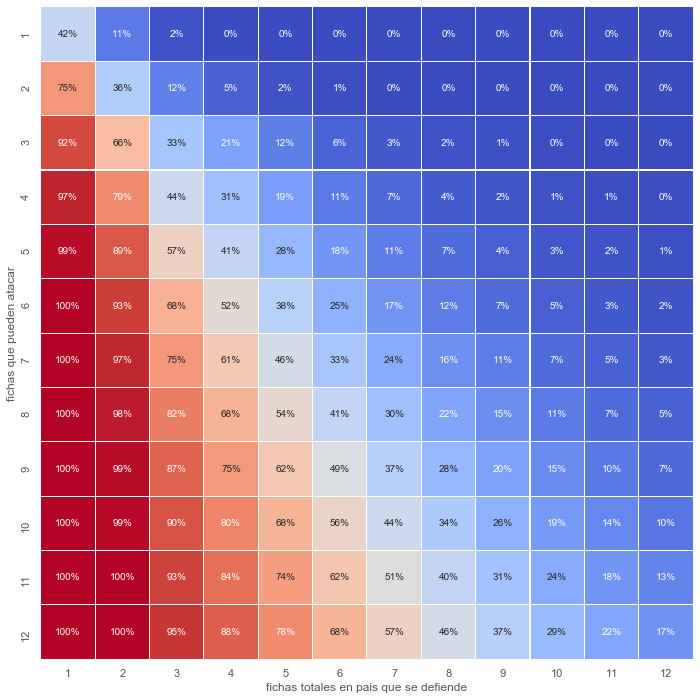

In [381]:
fig, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(prob_table, square=True, annot=True, center=0.5, cmap='coolwarm', fmt='.0%', linewidths=0.1, linecolor='white',cbar=False, ax=ax)
plt.show()

You can see that for small battles, you need to have more attackers than defenders to have better than 50-50 odds in _Risk_. This is because the defender wins on ties.

After the attacker has 5 armies, however, the attacker has better than even odds with an equal number of armies. This is because the attacker can roll 3 dice, while the defender can roll only 2.

#### Battle Win Probabilities by Matchup

Another way to look at the results is to plot the win probabilities of various matchups. Here's a plot.

In [333]:
prob_curves = df[df['def'].isin([1, 2, 3, 4, 5, 10, 15, 20])].pivot(
    index='att',
    columns='def',
    values='prob_att_wins'
)
prob_curves.columns.name = 'defenders'
prob_curves.index.name = 'attackers'

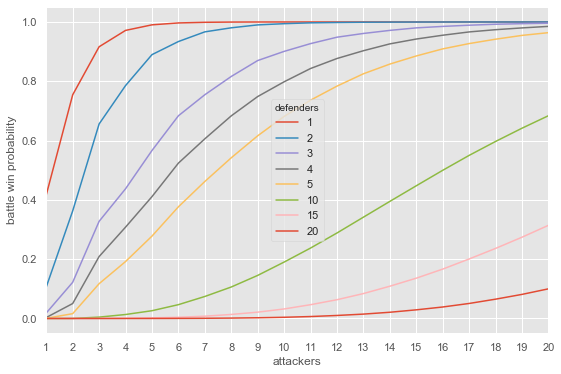

In [340]:
fig, ax = plt.subplots(figsize=(9, 6))
ax = prob_curves.plot.line(
    ax=ax,
    xticks=prob_curves.index,
)
ax.set_ylabel('battle win probability')
plt.show()

This plot is interesting. You can see how the slope of the probability curves change as the number of attackers increases. When the number of attackers equals the number of defenders, the curves look like relatively straight lines. When the number of attackers is much less than the number of defenders, the curves start off more horizontal, then start sloping up steeply. Of course, when the number of attackers is much larger than the number of defenders, the attacker is almost certain to win the battle. This means that the probability curve has to be pretty close to horizontal near the value 1.

#### Battle Win Probabilities by Attacker Advantage

Here's another interesting way to visualize the _Risk_ battle probabilities. Let's call how many more armies the attacker has than the defender the _attacker advantage_. We can look at how much the attacker advantage impacts the battle win probability, as we vary the number of attacker armies.

First, let's define a small function to extract the win probabilities for a given attacker advantage, and return them as a column. Notice that in our original table of win probabilities, the values with constant attacker advantage are on the _diagonal_ going down and to the right. The values with attacker advantage of 1 are, for example, (2, 1), (3, 2), (4, 3) and so on.

In [335]:
def att_prob_by_advantage(df, n):
    return (
        df.loc[df['att'] - df['def'] == n, ['att', 'prob_att_wins']]
        .rename(columns={'prob_att_wins': n})
        .set_index('att')
    )

Now that we have this function, we can use it to create a new table lined up the way we need. Notice that this table has `nan` (meaning "not-a-number' in `numpy` and `pandas`) for matchups that don't make sense. There's no way to have a 1-on-1 battle with an attacker advantage of 1, for example. Fortunately, `pandas` will ignore these `nan` values in making the plot.

In [336]:
prob_by_adv = pd.concat([att_prob_by_advantage(df, n) for n in range(0, 8)], axis='columns')
prob_by_adv.columns.name = 'attacker advantage'
prob_by_adv.index.name = 'attackers'
prob_by_adv

attacker advantage,0,1,2,3,4,5,6,7
attackers,,,,,,,,
1,0.417,nan,nan,nan,nan,nan,nan,nan
2,0.363,0.754,nan,nan,nan,nan,nan,nan
3,0.328,0.656,0.916,nan,nan,nan,nan,nan
4,0.308,0.437,0.785,0.972,nan,nan,nan,nan
5,0.278,0.411,0.567,0.890,0.990,nan,nan,nan
6,0.255,0.377,0.524,0.684,0.934,0.997,nan,nan
7,0.238,0.332,0.462,0.606,0.755,0.967,0.999,nan
8,0.219,0.304,0.410,0.542,0.683,0.816,0.980,1.000
9,0.203,0.280,0.373,0.486,0.616,0.748,0.870,0.990


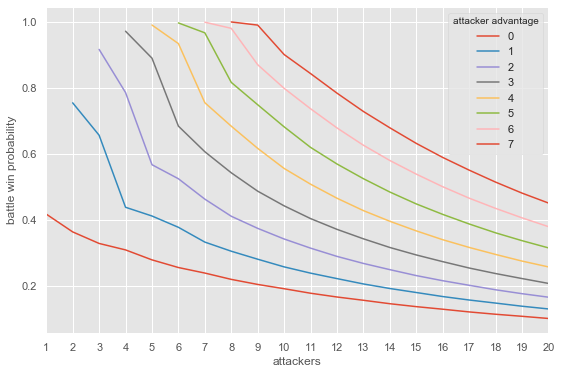

In [337]:
fig, ax = plt.subplots(figsize=(9, 6))
ax = prob_by_adv.plot(ax=ax, xticks=prob_by_adv.index)
ax.set_ylabel('battle win probability')
plt.show()

The bottommost (red) curve is for an attacker advantage of zero: the even-army matchup we already looked at. You can see how it exceeds 50% when the attacker has more than 5 armies. The line continues to rise slowly as the number of attacker armies increases.

With a 1- or 2-army attacker advantage, the curves drop quickly and then become relativley flat around 65-75% win probability. For _Risk_ battles with more than 5 attacking armies and a 1- or 2-army defender advantage, you can just remember the rule of thumb that the attacker should win around 70% of the battles.

It seems like the curves are gradually converging as the number of armies increase. Let's see what the values are for 100 attacking armies.

In [338]:
float(battle_outcomes((100, 100)).prob(attacker_wins))

0.0016862523740338508

In [339]:
float(battle_outcomes((107, 100)).prob(attacker_wins))

0.004692279636173258

So yes, the curves are closer together when the number of armies gets very large. The even-matchup curve is up over 80% win probabilty, while the curve for 7 attacker advantage is down to 91.5%, not much less than it is at 20 armies in the plot above.

### Closing Thoughts

For the larger attacker advantages in the plot above, the curves slope down over the entire range we examined here. This means that on a relative basis, your win probability is getting _worse_ as your throw more attackers into the battle. The analysis says you have better odds of success attacking 15-on-8 compared with 20-on-13.

There's clearly more going on here than meets the eye. It turns out that win probability isn't the only way (or the best way) to analyze _Risk_, since it ignores how many armies the attacker can expect to have left over even if she wins. If you have a high probability of winning an attack, but will lose an enormous number of armies in the process, the attack might not make sense.

We'll look at these issues in more detail in future posts.